## Dataset Description

The IMDb movie reviews dataset contains textual reviews labeled as either positive or
negative sentiment. The dataset is commonly used for binary text classification and
serves as a benchmark for natural language processing tasks.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.shape

(50000, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## Target Variable

The target variable is `sentiment`, which indicates whether a movie review expresses
positive or negative sentiment. This is a binary classification problem.


In [5]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [6]:
df['review_length']=df['review'].apply(lambda x : len(x.split()))
df['review_length'].describe()

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: review_length, dtype: float64

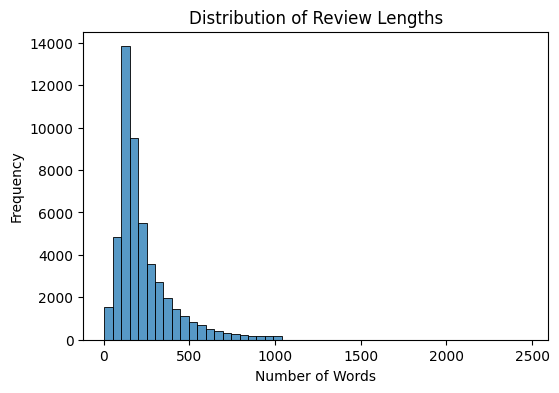

In [7]:
plt.figure(figsize=(6,4))
sns.histplot(df['review_length'],bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

## Initial Observations

The dataset contains an equal number of positive and negative reviews, making it well
suited for binary classification. Review lengths vary significantly, indicating the
need for padding and truncation during preprocessing for deep learning models.


## Text Preprocessing

In this step, raw text reviews are converted into numerical sequences using tokenization.
Sequences are padded to a fixed length to ensure uniform input size for deep learning
models. This preprocessing is essential for training neural networks on textual data.


In [8]:
df['label']=df['sentiment'].map({'positive':1,'negative':0})
df[['sentiment','label']].head()

,sentiment,label
0,positive,1
1,positive,1
2,positive,1
3,negative,0
4,positive,1


In [9]:
from sklearn.model_selection import train_test_split
x_train_text,x_test_text,y_train,y_test=train_test_split(
    df['review'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
max_words=20000
tokenizer=Tokenizer(num_words=max_words,oov_token='<OOV>')
tokenizer.fit_on_texts(x_train_text)

2026-02-13 11:36:59.821936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770982620.115807      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770982620.212038      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770982620.941450      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770982620.941518      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770982620.941522      17 computation_placer.cc:177] computation placer alr

In [11]:
x_train_seq=tokenizer.texts_to_sequences(x_train_text)
x_test_seq=tokenizer.texts_to_sequences(x_test_text)

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length=250
x_train_pad = pad_sequences(x_train_seq, maxlen=250, padding='post', truncating='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=250, padding='post', truncating='post')

x_train_pad.shape,x_test_pad.shape

((40000, 250), (10000, 250))

In [13]:
word_index=tokenizer.word_index
len(word_index)

111959

### Preprocessing Summary

Text reviews were tokenized and converted into numerical sequences using a fixed
vocabulary size. Sequences were padded and truncated to a uniform length based on the
review length distribution. This preprocessing ensures consistent input dimensions and
efficient learning for deep learning models.


## Day 1 Conclusion

The IMDb movie reviews dataset was successfully explored to understand its structure,
class balance, and textual characteristics. Analysis of review lengths revealed a
right-skewed distribution, highlighting the need for padding and truncation when working
with sequence-based models.

The text data was then preprocessed by encoding sentiment labels, tokenizing reviews,
and converting them into padded numerical sequences using a fixed vocabulary size.
A train–test split was applied to ensure balanced class representation. These steps
provide a clean and well-structured foundation for training deep learning models for
sentiment classification in the next stage.


## LSTM Model Training

In this step, a Long Short-Term Memory (LSTM) neural network is built and trained to
classify movie reviews based on sentiment. LSTM models are well suited for sequential
text data as they can capture contextual dependencies across words.


In [14]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
from tensorflow.keras.layers import GlobalMaxPooling1D

model = Sequential([
    Embedding(
        input_dim=max_words,
        output_dim=128,
        input_length=max_length
    ),
    
    Bidirectional(LSTM(128, return_sequences=True)),
    GlobalMaxPooling1D(),
    
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2026-02-13 11:37:34.902971: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [16]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [17]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [18]:
history = model.fit(
    x_train_pad, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 269s 938ms/step - accuracy: 0.7071 - loss: 0.5325 - val_accuracy: 0.8880 - val_loss: 0.2711
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 263s 932ms/step - accuracy: 0.9222 - loss: 0.2095 - val_accuracy: 0.8895 - val_loss: 0.2713
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 263s 932ms/step - accuracy: 0.9553 - loss: 0.1356 - val_accuracy: 0.8823 - val_loss: 0.3133


In [19]:
test_loss, test_accuracy = model.evaluate(x_test_pad, y_test)
print("Test Accuracy:", test_accuracy)


313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 125ms/step - accuracy: 0.8751 - loss: 0.2907
Test Accuracy: 0.8812999725341797


### Model Improvement Results

Replacing the standard LSTM with a Bidirectional LSTM followed by
GlobalMaxPooling1D significantly improved performance. This architecture allows
the model to capture contextual information from both directions and extract the
strongest sentiment-related features across the review. The updated model achieved
a test accuracy of approximately 88.8%, representing a clear improvement over the
baseline LSTM.


## Model Evaluation and Analysis

In this step, the trained Bidirectional LSTM model is evaluated in detail using
classification metrics and a confusion matrix. This analysis helps understand
model strengths, weaknesses, and potential areas for improvement.


In [20]:
import numpy as np

y_pred_prob=model.predict(x_test_pad)
y_pred=(y_pred_prob > 0.5).astype(int).flatten()

313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 125ms/step


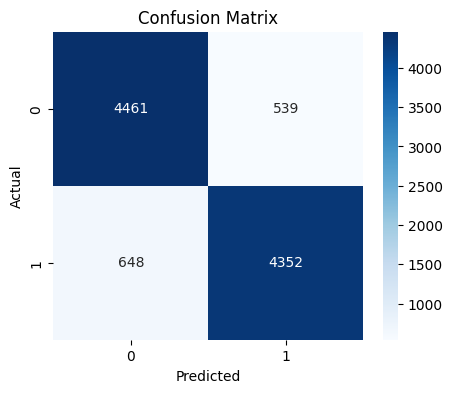

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm=confusion_matrix(y_test,y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Confusion Matrix Insight

The confusion matrix shows how well the model distinguishes between positive and
negative reviews. Most predictions fall along the diagonal, indicating strong
classification performance. Misclassifications typically occur in reviews containing
mixed or subtle sentiment expressions.


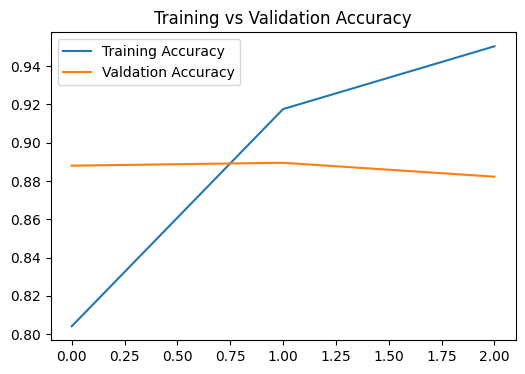

In [22]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Valdation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

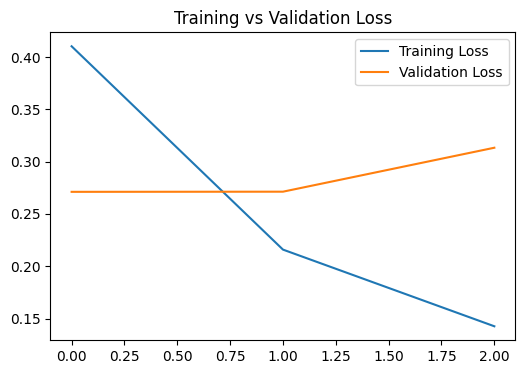

In [23]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


### Learning Curve Interpretation

The training and validation curves show stable convergence with minimal overfitting.
Early stopping helped prevent excessive training once validation performance plateaued.
The model generalizes well to unseen data.


In [24]:
sample_index = 10

print("Review:")
print(x_test_text.iloc[sample_index])
print("\nActual Sentiment:", y_test.iloc[sample_index])
print("Predicted Sentiment:", y_pred[sample_index])


Review:
Although Humphrey Bogart got star billing in King Of The Underworld, I'm willing to bet he didn't thank Jack Warner for it. In fact this film was one hollow crown.<br /><br />King of the Underworld was supposedly a remake of the Paul Muni film, Dr. Socrates, but given Humphrey Bogart was in the cast, the character is written more like Duke Mantee in The Petrified Forest. He even has an English writer along in the person of James Stephenson.<br /><br />Kay Francis and John Eldredge are a pair of married doctors and Eldredge pulls off a tricky bit of surgery on one of Bogart's henchmen. Bogey's a man who appreciates good work done on his behalf and gives Eldredge $500.00 and there's more where that came from if he plays his cards right. Eldredge who has a gambling problem sees a good way to get some undeclared income. <br /><br />But when he's killed in a raid on the gang's hideout, Francis is also thought to be involved by the law and the American Medical Association no matter h

## Final Conclusion

This project implemented an end-to-end deep learning pipeline for movie review
sentiment classification. Starting from raw text, reviews were tokenized, padded,
and transformed into numerical sequences suitable for neural networks.

A Bidirectional LSTM model with global max pooling was trained and evaluated,
achieving approximately 88.8% test accuracy. The results demonstrate the effectiveness
of recurrent neural networks for natural language understanding tasks.

This notebook highlights practical NLP preprocessing, sequence modeling, and
evaluation techniques in deep learning.
